In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import SAGEConv, global_mean_pool
from torch_geometric.utils import softmax

import matplotlib.pyplot as plt
import pandas as pd

import os
import sys
sys.path.append(os.path.join(os.path.abspath(''), '..'))
from utils.graph import grid_to_graph, graph_to_grid

In [2]:
class GraphDataset(Dataset):
    def __init__(self, root):
        super(GraphDataset, self).__init__(root)
        self.root = root
        self.file_names = os.listdir(root)

    def len(self):
        return len(self.file_names)

    def get(self, idx):
        return torch.load(os.path.join(self.root, self.file_names[idx]))

In [3]:
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = SAGEConv(13, 16, aggr='add')
        self.conv2 = SAGEConv(16, 32, aggr='add')
        self.lin1 = torch.nn.Linear(13 + 32, 16)
        self.lin2 = torch.nn.Linear(16, 1)

    def forward(self, data):
        x, edge_index, mask, batch = data.x, data.edge_index, data.mask, data.batch
        x_global = global_mean_pool(x, batch)

        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        

        x_combined = torch.cat([x, x_global[batch]], dim=1)
        x_combined = F.relu(self.lin1(x_combined))
        logits = self.lin2(x_combined)
        
        masked_logits = logits.clone()
        masked_logits[~mask] = -1e12

        return softmax(masked_logits, batch)

In [4]:
dataset = GraphDataset('../data/processed/')
loader = DataLoader(dataset, batch_size=100, shuffle=True)

model = GNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

epochs = 1
for epoch in range(epochs):
    for i, data in enumerate(loader):
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.kl_div(output, data.y, reduction='batchmean')
        loss.backward()
        optimizer.step()
        print(f'Epoch: {epoch}, Batch: {i}, Loss: {loss.item()}')

Epoch: 0, Batch: 0, Loss: -0.0029738841112703085
Epoch: 0, Batch: 1, Loss: -0.0027135328855365515
Epoch: 0, Batch: 2, Loss: -0.0028715957887470722
Epoch: 0, Batch: 3, Loss: -0.0028329617343842983
Epoch: 0, Batch: 4, Loss: -0.00279445038177073
Epoch: 0, Batch: 5, Loss: -0.0028863621409982443
Epoch: 0, Batch: 6, Loss: -0.0027115794364362955
Epoch: 0, Batch: 7, Loss: -0.002752320608124137
Epoch: 0, Batch: 8, Loss: -0.002655270043760538
Epoch: 0, Batch: 9, Loss: -0.0028121722862124443


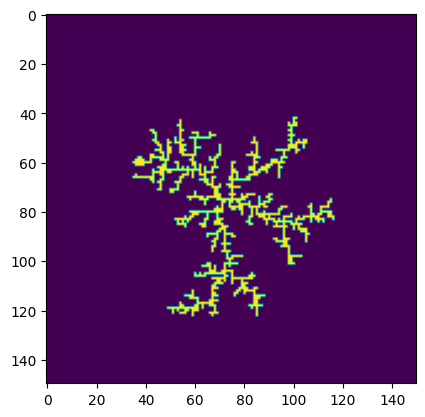

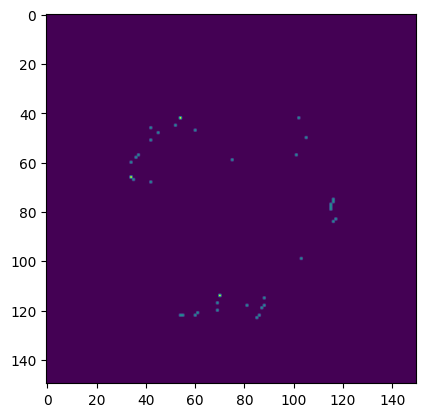

In [5]:
grid_df = pd.read_parquet('../data/0b362cee-93de-4351-a234-a3513a304d1c_grid.parquet')
grid = grid_df.iloc[-1].to_numpy().reshape(150, 150)
distribution_df = pd.read_parquet('../data/0b362cee-93de-4351-a234-a3513a304d1c_distribution.parquet')
distribution = distribution_df.iloc[-1].to_numpy().reshape(150, 150)

plt.imshow(grid)
plt.show()
plt.imshow(distribution);

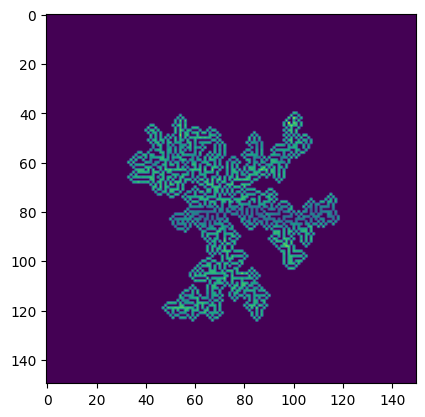

In [8]:
node_positions, edges, mask, input_nodes, target_nodes = grid_to_graph(grid, distribution)
node_positions = torch.tensor(node_positions, dtype=torch.long)
edges = torch.tensor(edges, dtype=torch.long).t().contiguous()
mask = torch.tensor(mask, dtype=torch.bool)
input_nodes = torch.tensor(input_nodes, dtype=torch.float)
target_nodes = torch.tensor(target_nodes, dtype=torch.long)
batch = torch.zeros(len(input_nodes), dtype=torch.long)

data = Data(x=input_nodes, edge_index=edges, y=target_nodes, pos=node_positions, mask=mask, batch=batch)
data.to(device)

model.to(device)
model.eval()
with torch.no_grad():
    output_nodes = model(data).cpu().detach().numpy()
    node_positions = node_positions.cpu().detach().numpy()
    plt.imshow(graph_to_grid(node_positions, output_nodes))